This notebook demonstrates implementing small-grid dithers (SGDs) for NIRCam in Pandeia. By default, the Pandeia engine relies on a library of sparsely-sampled, pre-computed PSFs which are spatially interpolated to produce the PSF at any given point. SGDs are an attempt to introduce PSF diversity by sampling variations that arise with small-scale offsets behind the coronagraph masks, so relying on this pre-computed library may not be appropriate. We therefore demonstrate SGDs with this library and by computing PSFs on-the-fly with WebbPSF.

This notebook assumes you've already look through the miri/nircam_photon_noise_and_contrast.ipynb notebooks, which demonstrate more basic functionality.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

from pandeia_coronagraphy import scene, analysis, transformations, engine

from copy import deepcopy
import numpy as np

# Scene Construction

Here, we'll simply read in a template with predefined targets and planets.

In [2]:
# Load the template
target = engine.load_calculation( engine.get_template('miri_coronagraphy_planets.json') )

# Add target acquisition error
errx, erry = scene.get_ta_error()
scene.offset_scene(target['scene'],errx,erry)

For the reference, we'll simply copy the target scene, toss out the planets, and modify the star.

In [3]:
reference = deepcopy(target)
star = reference['scene'][0]
# Reset offset
star['position']['x_offset'] = 0.
star['position']['y_offset'] = 0.
# Modify spectrum and magnitude
star['spectrum']['sed'] = 'a3v'
star['spectrum']['normalization']['norm_flux'] = 4.
# Replace scene definition with just this star
reference['scene'] = [reference['scene'][0]]

# Add a unique TA error
errx_ref, erry_ref = scene.get_ta_error()
scene.offset_scene(reference['scene'],errx_ref,erry_ref)

To simulate a small-grid dither (SGD), pass in a reference calculation file (after adding TA error) to the ```scene.create_SGD``` function. By default, this only supports a square 9-point grid with 2 mas error on the grid points, but this function can be easily reproduced for other SGD configurations.

In [4]:
sgds = scene.create_SGD(reference,stepsize=20.e-3)

And now we'll plot the two scenes we've constructed

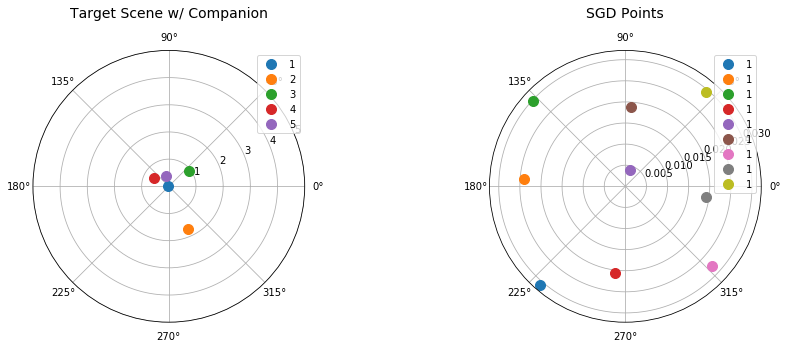

In [5]:
plt.figure(figsize=(15,5))
plt.subplot(121,polar=True)
scene.plot_scene(target['scene'],'Target Scene w/ Companion',newfig=False)
ax = plt.gca()
ax.set_rlim(0,5.)
plt.subplot(122,polar=True)
for s in sgds:
    scene.plot_scene(s['scene'],'SGD Points',newfig=False)
ax = plt.gca()

# Precomputed Library

In [6]:
engine.wave_sampling = 20
engine.on_the_fly_PSFs = False
sgd_results = engine.calculate_batch(sgds)
targ_results = engine.perform_calculation(target)

/Users/kgorkom/anaconda/envs/pandeia/lib/python2.7/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)
/Users/kgorkom/anaconda/envs/pandeia/lib/python2.7/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)
/Users/kgorkom/anaconda/envs/pandeia/lib/python2.7/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)
/Users/kgorkom/anaconda/envs/pandeia/lib/python2.7/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)
/Users/kgorkom/anaconda/envs/pandeia/lib/pyt

After registering the SGD observations to the target image, treat the SGD results as a reference library for KLIP and generate an artificial PSF for reference-subtraction

In [7]:
target_slope = targ_results['2d']['detector']

sgd_reg = []
for r in sgd_results:
    slope = r['2d']['detector']
    reg = analysis.register_to_target(slope,target_slope,rescale_reference=True)
    sgd_reg.append(reg)
sgd_reg = np.array(sgd_reg)

centered_target = target_slope - np.nanmean(target_slope)
artificialPSF = analysis.klip_projection(centered_target,sgd_reg)

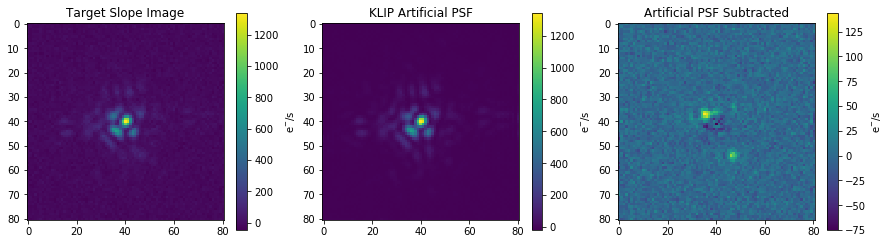

In [22]:
sgd_sub = centered_target - artificialPSF

plt.figure(figsize=(15,4))
plt.subplot(131)
plt.imshow(centered_target)
plt.title('Target Slope Image')
plt.colorbar().set_label('e$^{-}$/s')
plt.subplot(132)
plt.imshow(artificialPSF)
plt.title('KLIP Artificial PSF')
plt.colorbar().set_label('e$^{-}$/s')
plt.subplot(133)
plt.imshow(sgd_sub)
plt.title('Artificial PSF Subtracted')
plt.colorbar().set_label('e$^{-}$/s')

# On-the-fly PSFs

To enable on-the-fly PSFs with WebbPSF, simply toggle ```engine.on_the_fly_PSFs``` to ```True``` and re-submit the calculations as before.

NB: The number of PSFs generated is given by ```engine.wave_sampling``` * number of sources + ```engine.wave_sampling``` * SGD points. For this example, we're relying on WebbPSF for 280 calculations, which can take a long time. Subsequent calculations can be sped up by use of an [LRU cache](https://en.wikipedia.org/wiki/Cache_replacement_policies#Least_Recently_Used_.28LRU.29) (enabled by default), but this caching system is incompatible with multiprocessing, so ```engine.calculate_batch``` will not contribute to the cache, while ```engine.perform_calculation``` will.

In [23]:
engine.wave_sampling = 20
engine.on_the_fly_PSFs = True
sgd_results = engine.calculate_batch(sgds)
targ_results = engine.perform_calculation(target)

In [26]:
target_slope = targ_results['2d']['detector']

sgd_reg = []
for r in sgd_results:
    slope = r['2d']['detector']
    reg = analysis.register_to_target(slope,target_slope,rescale_reference=True)
    sgd_reg.append(reg)
sgd_reg = np.array(sgd_reg)

centered_target = target_slope - np.nanmean(target_slope)
artificialPSF = analysis.klip_projection(centered_target,sgd_reg)

After registering the SGD observations to the target image, treat the SGD results as a reference library for KLIP and generate an artificial PSF for reference-subtraction

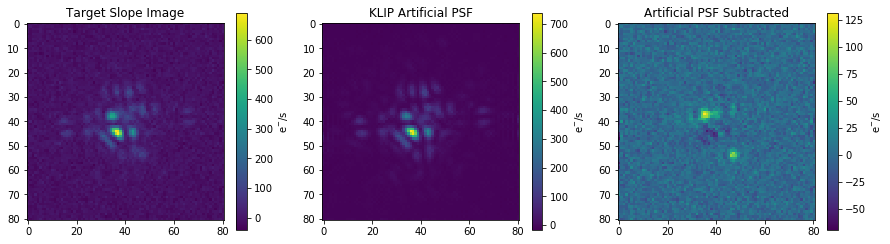

In [27]:
sgd_sub = centered_target - artificialPSF

plt.figure(figsize=(15,4))
plt.subplot(131)
plt.imshow(centered_target)
plt.title('Target Slope Image')
plt.colorbar().set_label('e$^{-}$/s')
plt.subplot(132)
plt.imshow(artificialPSF)
plt.title('KLIP Artificial PSF')
plt.colorbar().set_label('e$^{-}$/s')
plt.subplot(133)
plt.imshow(sgd_sub)
plt.title('Artificial PSF Subtracted')
plt.colorbar().set_label('e$^{-}$/s')